# Customer Churn Prediction + Clustering

12 features, ClusterChurn, Ensemble models : Random Forest and Gradient Boosted Trees.

## 1. Get ready

__Imports__

Import the necessary Spark classes, as well as Python packages for local visualisations.
We will plot the graphs directly in this notebook. If you like to plot them in a separate window, just comment out `%matplotlib inline`.

In [18]:
# Useful imports - PySpark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql import Row

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import ChiSqSelector
from pyspark.mllib.evaluation import BinaryClassificationMetrics

import numpy as np

from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
%local
%matplotlib inline

# Useful imports for local visualisations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

__Load the data__

Let's use a table which has been pre-populated in Db2 local. It is called SAMPLES.TRAINING. 

In [20]:
sparkSession = SparkSession \
        .builder \
        .getOrCreate()

df = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="SAMPLES.TRAINING") \
        .load()
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|CHURN|AREA|VMAIL|VMAIL_MSGS|DAY_MINS|DAY_CALLS|DAY_CHARGE|EVE_MINS|EVE_CALLS|EVE_CHARGE|NIGHT_MINS|NIGHT_CALLS|NIGHT_CHARGE|INTL_MINS|INTL_CALLS|INTL_CHARGE|SVC_CALLS|
+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|    0| 415|    1|         0|   246.5|      108|     41.91|   216.3|       89|     18.39|     179.6|         99|        8.08|     12.7|         3|       3.43|        2|
|    1| 408|    1|         0|   298.1|      112|     50.68|   201.3|      100|     17.11|     214.7|         88|        9.66|      9.7|         4|       2.62|        2|
|    0| 510|    1|         0|   119.3|       82|     20.28|   185.1|      111|     15.73|     157.0|         74|        7.07|     10.9|         4|       2.

How many records do we have? How many features?

In [21]:
print('Number of records: '+str(df.count()))
print('Number of features: '+str(len(df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of records: 3333
Number of features: 17

## 2. Prepare the data

__Split the data__

We split the data into three distinct sets: for training, validation and testing. We use the proportions 70%, 15% and 15% so that we keep a relatively high number of examples for training. Of course these proportions are subjective, you can change them if you want. We have defined a seed so that results can be reproduced.

In [22]:
train, val, test = df.randomSplit([0.70,0.15,0.15],1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3. Clustering

First, let's see if we can identify some customer clusters with KMeans. We will then apply logistic regression to predict churn.

### a. Apply unsupervised learning for customer segmentation with kMeans

Create a model: Build a Spark ML algorithm that selects the call counts from the customer data and clusters them using KMeans.

In [23]:
# We choose to keep the 12 most relevant features

assembler_12 = VectorAssembler(
    inputCols=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE"],
    outputCol="features")

# clusters will be built on training data only
train_12 = assembler_12.transform(train)

# Set characteristics of your model 
kmeans = KMeans().setK(15).setSeed(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Fit the model to the required training set and run the algorithm to find the clusters.

In [24]:
model = kmeans.fit(train_12)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
cluster_predictions = model.transform(train_12)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Inference__

KMeans is an unsupervized learning algorithm: we have to see if the clusters we have just built can be really be used to infer churn!

In [26]:
# Number of customers in each cluster
cluster_predictions.groupBy("prediction").count().sort("count").withColumnRenamed("prediction", "ClusterID").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|ClusterID|count|
+---------+-----+
|       13|  101|
|        5|  101|
|        9|  120|
|        2|  122|
|        8|  133|
|       14|  139|
|       10|  147|
|        7|  155|
|        1|  163|
|        6|  163|
|        4|  164|
|        0|  165|
|       11|  189|
|       12|  212|
|        3|  247|
+---------+-----+

__Silhouette score__

The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from −1 to +1. The closer to 1, the better: the object is then well matched to its own cluster and differs from the points belonging to neighboring clusters. If most objects have a high value, then the clustering configuration is considered to be appropriate. Otherwise there may be too many or too few clusters. Here we compute a mean value over all points, using the Euclidean distance.

In [27]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(cluster_predictions)
print("Silhouette with squared euclidean distance = %.3f " % silhouette)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Silhouette with squared euclidean distance = 0.305

* k=15

This allows to target even better our customers: churn propencies go from `4.9% to 57%` (comparison: 6 features : `5.1% to 65%`). We cannot increase the number of clusters too much if we do not have more data, because the model becomes more sensible to outliers.

In [28]:
# Churn proportion in each cluster
churn_proportion = cluster_predictions.groupBy("prediction").avg("CHURN").sort("avg(CHURN)").withColumnRenamed("prediction", "ClusterID")
churn_proportion.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|ClusterID|          avg(CHURN)|
+---------+--------------------+
|        1|0.049079754601226995|
|        3| 0.06882591093117409|
|       10| 0.07482993197278912|
|        7| 0.07741935483870968|
|       14| 0.07913669064748201|
|        5|  0.0891089108910891|
|        6| 0.09815950920245399|
|       11| 0.10052910052910052|
|        4| 0.10365853658536585|
|        8| 0.11278195488721804|
|        2| 0.13934426229508196|
|       12| 0.14150943396226415|
|        0| 0.14545454545454545|
|       13|  0.5445544554455446|
|        9|  0.5666666666666667|
+---------+--------------------+

### b. Use this new information as an additional feature

In [29]:
# Extract ClusterIDs and churn percentages for each cluster
churn_proportion_list = list(churn_proportion.select("avg(CHURN)").toPandas()["avg(CHURN)"])

ClusterID_list = list(churn_proportion.select("ClusterID").toPandas()["ClusterID"])

# Transform into a dictionary:
dico = {}
for i in range(len(ClusterID_list)):
    dico[ClusterID_list[i]] = churn_proportion_list[i]
print(dico)    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{1: 0.049079754601226995, 3: 0.06882591093117409, 10: 0.07482993197278912, 7: 0.07741935483870968, 14: 0.07913669064748201, 5: 0.0891089108910891, 6: 0.09815950920245399, 11: 0.10052910052910052, 4: 0.10365853658536585, 8: 0.11278195488721804, 2: 0.13934426229508196, 12: 0.14150943396226415, 0: 0.14545454545454545, 13: 0.5445544554455446, 9: 0.5666666666666667}

In [30]:
def preparation(DF):
    """
    Inputs : DF is a raw dataframe 
    Outputs : dataframe with additional colmns : features for Clustering, 
    Cluster prediction and corresponding cluster churn percentage
    """

    # We choose to keep only 6 features here (leads to higher cluster separation)
    #assembler_6 = VectorAssembler(inputCols=["TOT_MINS", "VMAIL", "INTL_CALLS", "DAY_CALLS", "SVC_CALLS", "DAY_CHARGE"], outputCol="features")

    # assemble 
    DF_12 = assembler_12.transform(DF)
    
    # Assign each point of the training set to its cluster
    DF_with_clusterIDs = model.transform(DF_12)

    # Create a new dataframe corresponding to the churn percentages for each point
    avgChurn = DF_with_clusterIDs.rdd.map(lambda element : dico[element.prediction])
    row = Row("prediction") 
    avgChurn_df = avgChurn.map(row).toDF().withColumnRenamed("prediction", "ClusterChurn")
    
    # Join tables
    temp1 = avgChurn_df.toPandas()
    temp2 = DF_with_clusterIDs.toPandas()
    temp2["ClusterChurn"] = temp1["ClusterChurn"]
    DF_with_avg = spark.createDataFrame(temp2)
    
    DF_with_avg_renamed = DF_with_avg.withColumnRenamed("features", "featuresClustering").withColumnRenamed("prediction", "predictionClustering")
    print(DF_with_avg_renamed.count())
    
    return DF_with_avg_renamed

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
prepared_train = preparation(train)
prepared_val = preparation(val)
prepared_test = preparation(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2321
495
517

## 4. Apply supervised learning for churn prediction

__Prepare the data__

Select columns and set label names for training. Here we choose to reuse the 6 column selected above. You can test other options if you like.

In [32]:
# Define the assembler
LogReg_assembler = VectorAssembler(
    inputCols=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"],
    outputCol="features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# Transform your training set
assembled_train = LogReg_assembler.transform(prepared_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# Select only the label and features columns
labeled_train = assembled_train.select(assembled_train["features"], assembled_train["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### a. Random Forest

__Build your model__

In [35]:
from pyspark.ml.classification import RandomForestClassifier

# Define your model
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
# Fit the model
rfModel = rf.fit(labeled_train)
# Make predictions
pred_train = rfModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Area under Curve__

In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
binEval_AUROC = BinaryClassificationEvaluator().setMetricName("areaUnderROC").setRawPredictionCol("rawPrediction").setLabelCol("label")
print("Area under ROC: %.3f" % binEval_AUROC.evaluate(pred_train))

binEval_AUPRC = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")
print("Area under PR curve: %.3f" % binEval_AUPRC.evaluate(pred_train))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Area under ROC: 0.905
Area under PR curve: 0.797

__Visualize feature importance__

__Metrics and confusion matrix__


Let's have a look at some indicators.

* Confusion matrix 

<img src="confusionMatrix.png" width=800/>

Sensitivity = TP / (TP + FN), also called Recall

Specificity = TN / (TN + FP)

Precision = TP / (TP + FP)

Negative Predictive Value = TN / (TN + FN)

F1-score: 2 x Precision x Recall / (Precision + Recall)

Recall = 1 - FNR. 

In [37]:
# Metrics (1/2)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_train)
print("Accuracy = %.3f" % accuracy)

evaluatorf1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(pred_train)
print("f1 = %.3f" % f1)
 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
wp = evaluatorwp.evaluate(pred_train)
print("weightedPrecision = %.3f" % wp)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy = 0.938
f1 = 0.931
weightedPrecision = 0.939

In [38]:
# Metrics (2/2)

def confusion_matrix(pred_DF):
    """
    Input : 
    pred_DF : Saprk DataFrame obtained after a model.transform() transformation
    Output :
    (tn, fp, fn, tp) tuple of integers
    """
    
    # as pandas DF
    label = pred_DF.toPandas()["label"]
    prediction = pred_DF.toPandas()["prediction"]
    
    # true = tp + tn
    true = sum(label)

    # tp : sum(if pred = label = 1) or count(pred+label=2)
    tp = sum(label+prediction==2)
    
    # fn = total number of positive - predicted positives which are rightly predicted
    fn = true - tp

    # tn : sum(if pred=label=0) or count(pred+label=0)
    tn = sum(label+prediction==0)

    # fp = total number of negative - tn
    fp = len(label) - true - tn
    
    return (tn, fp, fn, tp)


def FNR(fn, tp):
    return fn/(fn+tp)

def recall(tp, fn):
    # also called TPR or sensitivity
    return tp/(tp+fn)

def precision(tp, fp):
    return tp/(tp+fp)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_train)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# Metrics
print("FNR: %.3f" % FNR(fn, tp))
print("Recall: %.3f" % recall(tp, fn))
print("Precision: %.3f" % precision(tp, fp))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion matrix: 
[['tp: 191' 'fn: 138']
 ['fp: 7' 'tn: 1985']]
FNR: 0.419
Recall: 0.581
Precision: 0.965

__Fine tune your hyperparameters on the validation set__

We will only do it for logistic regression, since it is the more promising model so far. A similar method can be applied for the other model types.

In the following cell, default values are used for logistic regression's parameters. 

In [40]:
# Transform your validation set
assembled_val = LogReg_assembler.transform(prepared_val)

# Select only the label and features columns
labeled_val = assembled_val.select(assembled_val["features"], assembled_val["CHURN"].alias("label"))

# Make predictions
pred_val = rfModel.transform(labeled_val)

# Define evaluator
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Compute the classification accuracy on the validation set
accuracy = evaluator.evaluate(pred_val)
print("Validation Accuracy = %.3f" %  accuracy)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Validation Accuracy = 0.905

__Grid search__ 

In the next cell we define a function to test a range of hyperparameters for regularization in order to minimize the False Negative Rate (FNR).

> class pyspark.ml.classification.RandomForestClassifier(self, featuresCol="features", labelCol="label", predictionCol="prediction", probabilityCol="probability", rawPredictionCol="rawPrediction", `maxDepth=5`, `maxBins=32`, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity="gini", `numTrees=20`, featureSubsetStrategy="auto", seed=None, subsamplingRate=1.0)

In [41]:
def grid_search():
    """
    Input:
    DF : Spark Dataframe, prepared with features and label columns
    
    Output:
    best: dictionary with best hyperparameters and corresponding metrics
    """
       
    # Hyperparameter ranges
    maxDepth=[5, 10]
    maxBins=[32, 64]
    numTrees=[15, 20, 25]
    
    best={"maxDepth": 5, "maxBins": 32, "numTrees": 20, "val_recall": 0}
          
    for D in maxDepth:
        for B in maxBins:
            for T in numTrees : 

                # Define your model
                rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

                # Fit the model on training set
                rfModel = rf.fit(labeled_train)

                # Make predictions
                pred_val = rfModel.transform(labeled_val)

                # Compute the confusion matrix and FNR for both sets
                (tn, fp, fn, tp) = confusion_matrix(pred_val)
                val_recall = recall(tp, fn)
                
                #print("Validation FNR = " +str(val_FNR))
                #print("")

                if val_recall >= best["val_recall"]: # to have more regularization for equal performance
                    best["maxDepth"] = D
                    best["maxBins"] = B
                    best["numTrees"] = T
                    best["val_recall"] = val_recall
                
    return best

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
best = grid_search()
print(best)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'maxDepth': 10, 'maxBins': 64, 'numTrees': 25, 'val_recall': 0.524390243902439}

__Assess your model performance on the test set__

See what is the final perfomance of your tuned model on unseen data.

In [43]:
# Prepare the test set
assembled_test = LogReg_assembler.transform(prepared_test)

# Select only the label and features columns
labeled_test = assembled_test.select(assembled_test["features"], assembled_test["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
# Define your model
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', 
                            maxDepth = best["maxDepth"], maxBins = best["maxBins"], numTrees = best["numTrees"])

# Fit the model on training set
rfModel = rf.fit(labeled_train)

# Make predictions on test set
pred_test = rfModel.transform(labeled_test)
pred_test.show(5)

# Compute the accuracy on the test set
print("Test Accuracy = %.3f" %evaluator.evaluate(pred_test))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,199.1,33.85,...|    0|[23.6570898551729...|[0.94628359420691...|       0.0|
|[0.0,204.9,34.83,...|    0|[24.5029872713351...|[0.98011949085340...|       0.0|
|[1.0,291.1,49.49,...|    0|          [21.0,4.0]|         [0.84,0.16]|       0.0|
|[1.0,141.8,24.11,...|    0|[24.5299542194007...|[0.98119816877603...|       0.0|
|[0.0,306.2,52.05,...|    0|          [23.0,2.0]|         [0.92,0.08]|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

Test Accuracy = 0.925

In [45]:
# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# FNR
print("FNR: %.3f" %FNR(fn, tp))
print("recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion matrix: 
[['tp: 41' 'fn: 31']
 ['fp: 8' 'tn: 437']]
FNR: 0.431
recall: 0.569

Comparison : Logistic regression
* (22, 50, 12, 433) FNR: 0.694 - 12 features + ClusterChurn
* (18, 54, 4, 441) FNR = 0.750 - 6 features + ClusterChurn
* (12, 60, 4, 441), FNR = 0.833 without ClusterChurn column 

__Feature importance__ 

In [46]:
rfModel.featureImportances

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparseVector(13, {0: 0.1818, 1: 0.1601, 2: 0.0839, 3: 0.0483, 4: 0.0388, 5: 0.0395, 6: 0.0411, 7: 0.0452, 8: 0.0805, 9: 0.0685, 10: 0.0397, 11: 0.0379, 12: 0.1347})

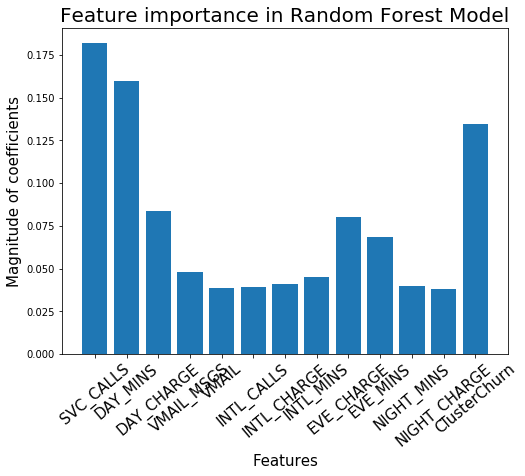

In [47]:
%local

import matplotlib.pyplot as plt
import numpy as np

dic = {0: 0.1818, 1: 0.1601, 2: 0.0839, 3: 0.0483, 4: 0.0388, 5: 0.0395, 6: 0.0411, 7: 0.0452, 8: 0.0805, 9: 0.0685, 10: 0.0397, 11: 0.0379, 12: 0.1347}
features = ["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS", "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"]
coeffs = [x for x in dic.values()]

ax, fig=plt.subplots(figsize=(8,6))
index = np.arange(len(features))
plt.bar(index, coeffs)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients', fontsize=15)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance in Random Forest Model', fontsize=20)
plt.show()

### b.  Gradient Boosted Trees

__Hyperparameter tuning__

GBTClassifier(self, featuresCol="features", labelCol="label", predictionCol="prediction",
                 maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,
                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType="logistic",
                 maxIter=20, stepSize=0.1, seed=None, subsamplingRate=1.0)

In [60]:
def grid_search_GBT():
    """
    Input:
    DF : Spark Dataframe, prepared with features and label columns
    
    Output:
    best: dictionary with best hyperparameters and corresponding metrics
    """
       
    # Hyperparameter ranges
    maxDepth=[5, 10, 20]
    maxBins=[32, 64]
    stepSize=[0.05, 0.1]
    
    best={"maxDepth": 5, "maxBins": 32, "stepSize": 20, "val_recall": 0}
          
    for D in maxDepth:
        for B in maxBins:
            for s in stepSize : 

                # Define your model
                gbt = GBTClassifier(maxDepth=D, maxBins=B, stepSize=s)

                # Fit the model on training set
                gbtModel = gbt.fit(labeled_train)

                # Make predictions
                pred_val = gbtModel.transform(labeled_val)

                # Compute the confusion matrix and FNR for both sets
                (tn, fp, fn, tp) = confusion_matrix(pred_val)
                val_recall = recall(tp, fn)
                
                #print("Validation FNR = " +str(val_FNR))
                #print("")

                if val_recall >= best["val_recall"]: # to have more regularization for equal performance
                    best["maxDepth"] = D
                    best["maxBins"] = B
                    best["stepSize"] = s
                    best["val_recall"] = val_recall
                
    return best

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
best_GBT = grid_search_GBT()
print(best_GBT)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Assess your model's performance on the test set__

In [56]:
# Define your model
gbt = GBTClassifier(maxDepth=D, maxBins=B, stepSize=s)
                    
# Fit the model on training set
gbtModel = gbt.fit(labeled_train)

# Make predictions on test set
pred_test_GBT = gbtModel.transform(labeled_test)
pred_test_GBT.show(5)

# Compute the accuracy on the test set
print("Test Accuracy = %.3f" %evaluator.evaluate(pred_test))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__init__() got an unexpected keyword argument 'numTrees'
Traceback (most recent call last):
  File "/opt/ibm/dashdb_spark/spark/python/lib/pyspark.zip/pyspark/__init__.py", line 105, in wrapper
    return func(self, **kwargs)
TypeError: __init__() got an unexpected keyword argument 'numTrees'



Note : if you wonder what other hyperparameters you can modify, here is how to get the list with a succint description of each one.

In [55]:
print(gbt.explainParams())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'gbtModel' is not defined
Traceback (most recent call last):
NameError: name 'gbtModel' is not defined



In [52]:
# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test_GBT)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# FNR
print("FNR: %.3f" %FNR(fn, tp))
print("recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'pred_test_GBT' is not defined
Traceback (most recent call last):
NameError: name 'pred_test_GBT' is not defined



__Feature importance__

In [53]:
gbtModel.featureImportances

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'gbtModel' is not defined
Traceback (most recent call last):
NameError: name 'gbtModel' is not defined



In [54]:
%local

dic = ...
features = ["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS", "NIGHT_MINS", "NIGHT_CHARGE", "ClusterChurn"]
coeffs = [x for x in dic.values()]

ax, fig=plt.subplots(figsize=(8,6))
index = np.arange(len(features))
plt.bar(index, coeffs)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients', fontsize=15)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance in GBT Model', fontsize=20)
plt.show()

AttributeError: 'ellipsis' object has no attribute 'values'

In [ ]:
__Conclusion__

